In [2]:
import os
import pandas as pd
import numpy as np
import helpers

import transformers

from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

from sklearn.model_selection import train_test_split


2023-06-08 07:18:29.818697: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 07:18:31.475121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 07:18:32.471538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('./data/cub.csv', index_col=0)
df = df[df['species'] == 'yeasts288c']

In [4]:
df = helpers.add_codons_to_df(df, 'Sequence')
df.columns

Index(['GeneName', 'median_exp', 'Sequence', 'species', 'mlphi_est', 'CAI',
       'codons_cleaned'],
      dtype='object')

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=1234)

In [6]:
l = []

with open('./results/codonBERT_reg_output_yeasts288c-nopre.txt', 'r') as file:
    lines = file.readlines()
    
    for line in lines:
        l.append(float(line[1:-2]))
        
df_test['BERT-CUB'] = l

In [7]:
tokenizer_name = "./tokenizers/codonBERT"
model_name = "./models/codonBERT-binary-large_1/checkpoint-127330"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, token_type_ids=False, truncation=True, padding=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cpu()

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

/lustre/isaac/scratch/ababjac/pyvenv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
prob_0 = []
prob_1 = []
prob_2 = []
pred_label = []

count = 0

for elem in df_test['codons_cleaned']:
    
    if count % 100 == 0:
        print(count)
    
    count += 1
    
    if len(elem) > 1024:
        elem = elem[:1024]
    
    prediction = pipe([elem])
    pred = prediction[0]
    prob_0.append(pred[0]['score'])
    prob_1.append(pred[1]['score'])
    
    MAX = max([prob_0[-1], prob_1[-1]])
    
    if prob_0[-1] == MAX:
        pred_label.append(0)
    else:
        pred_label.append(1)
        
df_test['prob_0_binary'] = prob_0
df_test['prob_1_binary'] = prob_1
df_test['pred_binary'] = pred_label

0
100
200
300
400
500
600
700
800
900
1000


In [9]:
tokenizer_name = "./tokenizers/codonBERT"
model_name = "./models/codonBERT-multi-large_1/checkpoint-127330"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, token_type_ids=False, truncation=True, padding=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cpu()

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

/lustre/isaac/scratch/ababjac/pyvenv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [10]:
prob_0 = []
prob_1 = []
prob_2 = []
pred_label = []

count = 0

for elem in df_test['codons_cleaned']:
    
    if count % 100 == 0:
        print(count)
    
    count += 1
    
    if len(elem) > 1024:
        elem = elem[:1024]
    
    prediction = pipe([elem])
    pred = prediction[0]
    prob_0.append(pred[0]['score'])
    prob_1.append(pred[1]['score'])
    prob_2.append(pred[2]['score'])
    
    MAX = max([prob_0[-1], prob_1[-1], prob_2[-1]])
    
    if prob_0[-1] == MAX:
        pred_label.append(0)
    elif prob_1[-1] == MAX:
        pred_label.append(1)
    else:
        pred_label.append(2)

        
df_test['prob_0_multi'] = prob_0
df_test['prob_1_multi'] = prob_1
df_test['prob_2_multi'] = prob_2
df_test['pred_multi'] = pred_label

0
100
200
300
400
500
600
700
800
900
1000


In [11]:
df_test['actual_binary'] = np.where(df_test['median_exp'] > np.median(df['median_exp'].values), 1, 0)

low, high = df.median_exp.quantile([0.33, 0.67])
high_l = np.where(df_test['median_exp'] > high, 2, 0)
low_l = np.where(df_test['median_exp'] > low, 0, 1)
df_test['actual_multi'] = high_l+low_l

In [12]:
df_test['log_median_exp'] = np.log(df_test['median_exp'])

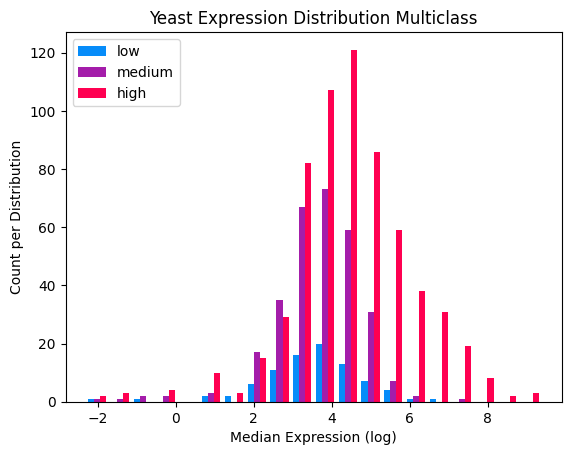

In [13]:
import matplotlib.pyplot as plt

a = df_test.loc[df_test['pred_multi'] == 0, 'log_median_exp']
b = df_test.loc[df_test['pred_multi'] == 1, 'log_median_exp']
c = df_test.loc[df_test['pred_multi'] == 2, 'log_median_exp']

plt.hist([b, a, c], bins=20, label=['low', 'medium', 'high'], color=['#068cf9', '#a41daa', '#ff0051'])

plt.legend(loc='upper left')
plt.title('Yeast Expression Distribution Multiclass')
plt.xlabel('Median Expression (log)')
plt.ylabel('Count per Distribution')

plt.show()

In [14]:
from scipy.stats import ttest_ind

print(ttest_ind(a, b, permutations=50, random_state=10))
print(ttest_ind(a, c, permutations=50, random_state=10))
print(ttest_ind(b, c, permutations=50, random_state=10))

Ttest_indResult(statistic=0.8837808829369758, pvalue=0.4117647058823529)
Ttest_indResult(statistic=-8.126677036661313, pvalue=0.0196078431372549)
Ttest_indResult(statistic=-5.329386868492606, pvalue=0.0196078431372549)


In [15]:
# for species in set(df['species']):
#     print(species)
#     _df = df[df['species'] == species]

#     a = _df.loc[_df['actual_multi'] == 0, 'CAI']
#     b = _df.loc[_df['actual_multi'] == 1, 'CAI']
#     c = _df.loc[_df['actual_multi'] == 2, 'CAI']

#     print(ttest_ind(a, b, permutations=50, random_state=10))
#     print(ttest_ind(a, c, permutations=50, random_state=10))
#     print(ttest_ind(b, c, permutations=50, random_state=10))
#     print()

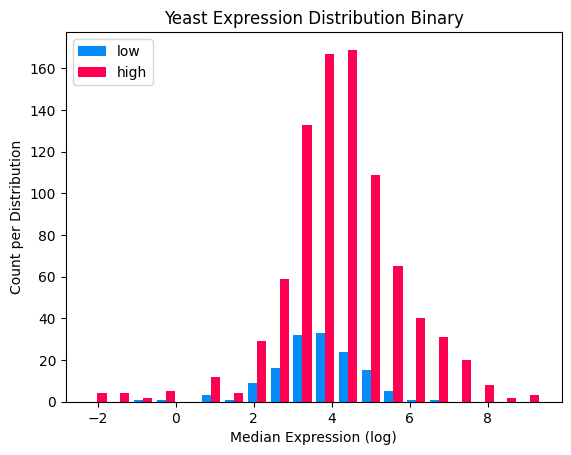

In [16]:
a = df_test.loc[df_test['pred_binary'] == 0, 'log_median_exp']
b = df_test.loc[df_test['pred_binary'] == 1, 'log_median_exp']

plt.hist([a, b], bins=20, label=['low', 'high'], color=['#068cf9', '#ff0051'])
plt.legend(loc='upper left')

plt.title('Yeast Expression Distribution Binary')
plt.xlabel('Median Expression (log)')
plt.ylabel('Count per Distribution')

plt.show()

In [17]:
from scipy.stats import ttest_ind

ttest_ind(a, b, permutations=50, random_state=10)

Ttest_indResult(statistic=-4.355589767754597, pvalue=0.0196078431372549)

In [18]:
# for species in set(df['species']):
#     print(species)
#     _df = df[df['species'] == species]
    
#     a = df.loc[df['actual_multi'] == 0, 'CAI']
#     b = df.loc[df['actual_multi'] == 1, 'CAI']

#     print(ttest_ind(a, b, permutations=50, random_state=10))
#     print()